In [3]:
import scipy as sp
import numpy as np

Обратная задача с использованием решения прямой задачи

In [ ]:
def Loss_direct(param: np.ndarray,
         loss_type : str,
         function_type: str,
         data: np.ndarray
         ) -> float:
    ''' Возвращает значение ошибки loss_type для среды с параметрами param и данных data, полученных для function_type
    
    parameters
    ----------
    param: numpy.ndarray
        Массив параметров среды формой (2N-1), ultN -количество слоёв в модели. param[2*(i-1)]=rhoa_i, i=1, ..., N; param[2*(i-1)+1] = thickness_i, i=1, ..., N-1
    loss_type: str
        Тип целевой функции
    function_type: str
        Тип минимизируемой функции: 'rhoa' - кажущееся сопротивление, 'u' - разность потенциалов, 'E' - электрическое поле    
    data: numpy.ndarray
        Массив формы (K,2), K = количество точек, data[i]=[r_i, f_i], r_i - полуразнос, f_i -измеренное значение    
    '''
    if loss_type == 'RSME':
        s = 0
        K = data.shape[0]
        # считаем сумму квадратов разности значений
        for i in range(K):
            s += np.square(data[i][1] - direct_problem(function_type, param, data[i][0])) # direct_problem - функция решающая прямую задачу для function_type в среде param и возвращающая значение function_type в точке r_i
        # возвращаем RMSE
        return np.sqrt(s/K)

In [ ]:
def inverse_problem(N_list : list,
                    function_type : str,
                    data : np.ndarray,
                    minimization_method : str = 'COBYLA',
                    loss_type : str = 'RSME',
                    thickness_max : float =10**3,
                    tolerance : float = 10**(-5)
                    ):
    '''Возвращает list из N_list[i]-слойных моделей в виде объекта класса scipy.optimize.OptimizeResult и индекс модели с минимальной ошибкой
    
    parameters
    ----------
    N_list: list
        Список из числа слоёв в моделях, среди которых будет происходить подбор наиболее подходящей  
    function_type: str
        Тип минимизируемой функции: 'rhoa' - кажущееся сопротивление, 'u' - разность потенциалов, 'E' - электрическое поле    
    data: numpy.ndarray
        Массив формы (K,2), K = количество измерений, data[i]=[r_i,f_i], r_i - полуразнос, f_i -измеренное значение
    minimization_method: str, optional
        Метод оптимизации для scipy.optimize.minimize. \n
        Доступные варианты: 'Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr'
    loss_type: str, optional
        Тип целевой функции
    thickness_max: float, optional
        Максимальная мощность слоёв в модели
    tolerance: float, optional
        tolerance для scipy.optimize.minimize
    '''
    # создание списков подобранных моделей и ошибокs
    results_list = []
    results_losses = []

    # ограничение на максимальное сопротивление слоёв
    rhoa_max = 2*max(data[:][1])
    
    for N in N_list:

        # Создание ограничений на rhoa, thickness для каждого слоя в scipy.optimize.minimize
        boundaries = []
        for i in range(N):
            boundaries.append((0,rhoa_max))
            boundaries.append((0,thickness_max))
        boundaries = tuple(boundaries[:-1])
        
        # Создание начальных значений rhoa, thickness для минимизации
        start_param=np.matmul(np.ones(shape=(N,1)).T*np.array([[rhoa_max/4, thickness_max/2]])).reshape(-1)
        
        # минимизация
        result = sp.optimize.minimize(fun = Loss_direct,
                                      x0 = start_param,
                                      args = (loss_type, function_type, data),
                                      method = minimization_method,
                                      bounds = boundaries, 
                                      tol = tolerance
                                      )
        
        # подобранные параметры записываются в список
        results_list.append(result)
        
        # ошибка записывается в список
        results_losses.append(result.fun)

    # возвращается модели и номер с минимальным значением ошибки loss_type
    return results_list, np.where(results_losses == np.min(results_losses))[0][0]       

Обратная задача с использованием обобщения двухслойной модели

In [4]:
def rhoa (r : np.ndarray,
          rho1 : float,
          rho2,
          h :float
          ) -> np.ndarray :
    ''' Возвращает значение кажущегося сопротивления на поверхности для двухслойной модели с сопротивлениями rho1, rho2 и мощностью первого слоя h при полуразносе r

    parameters
    ----------
    r: numpy.ndarray
        Полуразнос установки
    rho1: float
        Сопротивление верхнего слоя
    rho2: float или numpy.ndarray
        Сопротивление нижнего слоя. \n Если массив, то должен быть той же длины, что и r
    h: float
        мощность верхнего слоя   
    '''
    s = 0
    maxJ = 100
    for j in range (1, maxJ) :
        k12 = (rho2-rho1)/(rho2+rho1)
        s +=  r**3*k12**j /(r**2 + (2*j*h)**2)**(3/2)
    return rho1*(1 +2*s)

def aprox_rhoa_N_layers(r : np.ndarray,
                        param : np.ndarray
                        ) -> np.ndarray:
    ''' Возвращает значение кажущегося сопротивления на поверхности для N-слойной модели param при полуразносе r используя двухслойную модель

    parameters
    ----------
    r: numpy.ndarray
        Полуразнос установки
    param: numpy.ndarray
        Массив параметров среды формой (2N-1), ultN -количество слоёв в модели. param[2*(i-1)]=rhoa_i, i=1, ..., N; param[2*(i-1)+1] = thickness_i, i=1, ..., N-1
    '''
    N=int((param.shape[0]+1)/2) 
    if N != 1:
        # Сопротивление слоёв пересчитываются снизу вверх как кажущиеся сопротивления в двух-слойной модели 
        rk=rhoa(r,param[2*((N-2))], param[2*(N-1)], param[2*((N-1))-1])
        for i in range(1,N-1):
            rk=rhoa(r,param[2*((N-2-i))], rk, param[2*(N-2-i)+1])
        # Возвращаем кажущееся сопротивдение на поверхности
        return rk
    else:
        return param[0]

In [5]:
def loss_N_layers(param : np.ndarray,
                  loss_type: str,
                  data : np.ndarray
                  ) -> float:
    ''' Возвращает значение ошибки loss_type для N-слойной модели param и данных data, полученных для кажущегося сопротивления
    
    parameters
    ----------
    param: numpy.ndarray
        Массив параметров среды формой (2N-1), ultN -количество слоёв в модели. param[2*(i-1)]=rhoa_i, i=1, ..., N; param[2*(i-1)+1] = thickness_i, i=1, ..., N-1  
    loss_type: str
        Тип целевой функции       
    data: numpy.ndarray
        Массив формы (K,2), K = количество точек, data[i]=[r_i, f_i], r_i - полуразнос, f_i -измеренное значение    
    '''
    if loss_type == 'RSME':
        s = 0
        K = data.shape[0]
        # считаем сумму квадратов разности значений
        for i in range(K):
            s += np.square(data[i][1] - aprox_rhoa_N_layers(data[i][0], param))
        # возвращаем RMSE
        return np.sqrt(s/K)

In [6]:
def approx_inverse_problem(N_list : list,
                    data : np.ndarray,
                    minimization_method : str = 'COBYLA',
                    loss_type : str = 'RSME',
                    thickness_max : float =10**2,
                    tolerance : float = 10**(-5)
                    ):
    '''Возвращает list из N_list[i]-слойных моделей в виде объекта класса scipy.optimize.OptimizeResult и индекс модели с минимальной ошибкой
    
    parameters
    ----------
    N_list: list
        Список из числа слоёв в моделях, среди которых будет происходить подбор наиболее подходящей  
    data: numpy.ndarray
        Массив формы (K,2), K = количество измерений, data[i]=[r_i,f_i], r_i - полуразнос, f_i -измеренное значение
    minimization_method: str, optional
        Метод оптимизации для scipy.optimize.minimize. \n
        Доступные варианты: 'Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr'
    loss_type: str, optional
        Тип целевой функции
    thickness_max: float, optional
        Максимальная мощность слоёв в модели
    tolerance: float, optional
        tolerance для scipy.opnimize.minimize
    '''
    # создание списков подобранных моделей и их ошибок
    results_list = []
    results_losses = []

    # ограничение на максимальное сопротивление слоёв
    rhoa_max = 2*max(data[:][1])
    
    for N in N_list:

        # Создание ограничений на rhoa, thickness для каждого слоя в scipy.optimize.minimize
        boundaries = []
        for i in range(N):
            boundaries.append((0,rhoa_max))
            boundaries.append((0,thickness_max))
        boundaries = tuple(boundaries[:-1])
        # Создание начальных значений rhoa, thickness для минимизации
        start_param=np.matmul(np.ones((N,1)),np.array([[rhoa_max/2, thickness_max/2]])).reshape(-1)[:-1]
        
        # минимизация
        result = sp.optimize.minimize(fun = loss_N_layers,
                                      x0 = start_param,
                                      args = (loss_type, data),
                                      method = minimization_method,
                                      bounds = boundaries, 
                                      tol = tolerance
                                      )
        
        # подобранные параметры записываются в список
        results_list.append(result)
        
        # ошибка записывается в список
        results_losses.append(result.fun)

    # возвращается модели и номер с минимальным значением ошибки loss_type
    return results_list, np.where(results_losses == np.min(results_losses))[0][0]  

Проверил этот метод на тестовых данных из прошлого задания

In [7]:
import matplotlib.pyplot as plt

In [8]:
path_to_experimental_data='./BURM7.EXP'
f=open(path_to_experimental_data)
path_to_AB_MN_data=('./'+f.readline()).strip()
f.close()
dat = np.genfromtxt(path_to_experimental_data, comments= '$' , skip_header = 3)
experimental_rhoa = dat.T[2] # измеренные кажущиеся сопротивления
stt=np.genfromtxt(path_to_AB_MN_data,comments= '$')
AB2 = stt.T[0] # Полуразнос

In [9]:
N_layers_list=[2,3,4,5] # список из количества слоёв в моделях
exp_data=np.array([AB2, experimental_rhoa]).T # Данные
inverse=approx_inverse_problem(N_layers_list,exp_data) 
results=inverse[0] # модели полученные из обратной задачи 
ind=inverse[1] #  индекс модели с наименьшим loss_N_layers в results
ind

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


3

In [11]:
#Вывод количества слоёв в модели, её параметров и полученной ошибки
for i in range (len(N_layers_list)):
    print('\nnumber of layers= ', N_layers_list[i],' \nparam =',results[i].x,'\nloss =',results[i].fun)


number of layers= 2  
param= [103.31326888  87.38895012 590.10929646] 
loss= 32.211814869831045

number of layers= 3  
param= [146.50068887   8.9540229   46.30088073  33.72614    480.33807762] 
loss= 20.11033416884827

number of layers= 4  
param= [146.327104     8.93877195  46.10875309  26.49868146 135.28264954
  31.30891343 440.04616682] 
loss= 20.470978549240787

number of layers= 5  
param= [146.35050516   8.76012822  48.65208829  27.52960332 140.80684453
  31.11169201 133.85464863  16.43469966 471.35989961] 
loss= 18.679554275380756


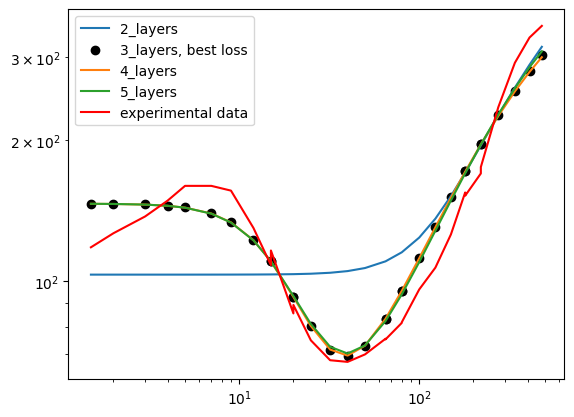

In [13]:
# Визуализация
for i in range(len(N_layers_list)):
    if N_layers_list[i]==ind:
        plt.scatter(AB2,aprox_rhoa_N_layers(AB2, results[i].x), c='black',label=f'{N_layers_list[i]}_layers, best loss')
    else: plt.loglog(AB2,aprox_rhoa_N_layers(AB2, results[i].x), label=f'{N_layers_list[i]}_layers')
plt.loglog(AB2,experimental_rhoa,c='red', label='experimental data')
plt.legend()

В отрисовке:
1) из result_inv=inverse_problem(), aprox_result=aprox_inverse_problem() достать параметры среды с помощью result_.x
2) построить на одном графике data[:][1] и inv_calculated_data=direct_problem(function_type, result_inv.x, data[:][0]), aprox_inv_calculated_data=direct_problem(function_type, aprox_result.x, data[:][0])
3) построить разницу между data и inv_calculated_data, aprox_inv_calculated_data
4) повторить 2 и 3 в 2D
